# Analysis of Titanic data
Here we try to analyse what all factors will influence the likelihood of survival of the passengers. This analysis could only be started if we ask correct questions like:

1. What was the survival rate on the Ship for the given data?
2. Which section/gender/class had higher survival rate?
3. Were there any specific indicators which can be identified that lead to higher survival rate?
4. Can we relate 2 or more aspects of data which indicates in higher survival rate?

The data provided contains lot of variables. We will start with segregating the people who survived to the people who could not. Then we will primarily analyse the people who survived and various facets that directly or indirectly affected their survival. The aspects could be directly related to higher survival or with the combination of other variables.

## 1. Let Us explore the Dataset 

### 1(a). We first segregate on the basis of the ones who survived and ones who could not

In [ ]:
from IPython.display import Image

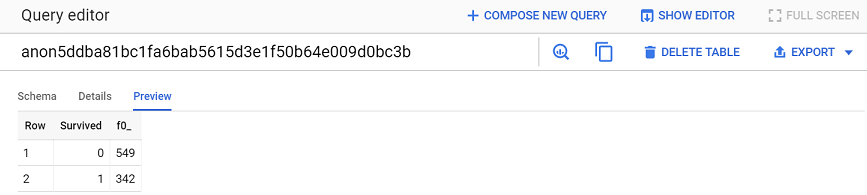

In [47]:
SELECT 
    Survived, 
    Count(*)
FROM `daring-span-249015.titanic_dataset.Train`
group by Survived ;

Image(filename='Images\Survived.PNG')

### 1(b). Now we try to form a relation between Sex and Survival

In [ ]:
Select 
    Sex , 
    Survived,
    count(*)
FROM `daring-span-249015.titanic_dataset.Train`
Group by  
    Survived , 
    Sex
order by 
    1 , 
    2;

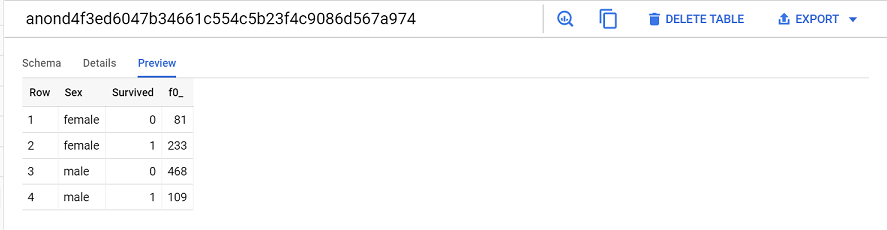

In [48]:
Image(filename='Images\Sex_Survived.PNG')

### Important Observation:

> So it is revealed that out of 577 males only 109 males survived, while out of 342 females 233 survived. This is a peculiar difference. So approximatly 1 in 5 males survived while 2 out of 3 females survived. This could have been because women and children might have been evacuated first.

## 1(c). Let us explore other features of the dataset as well starting with Age

In [ ]:
select 
    case
        when age <18 then 'Under 18'
        when age between 18 and 24 then '18-24'
        when age between 25 and 34 then '25-34'
        when age > 34 then '35 above'
    END as age_range, 
    Count(*) as count
from `daring-span-249015.titanic_dataset.Train`
group by age_range
order by age_range;

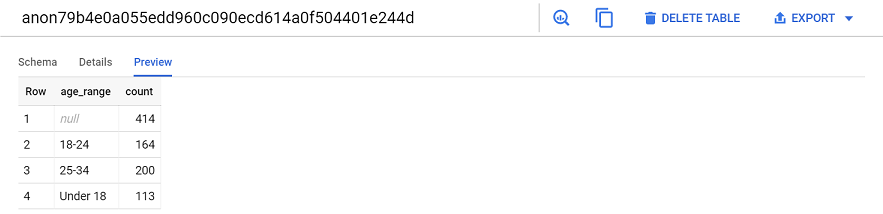

In [49]:
Image(filename='Images\Age.PNG')

> From the Output we can see there are Null Values also present in Age columns. Let us update these Ages with Mean Age of the complete group

In [ ]:
Update `daring-span-249015.titanic_dataset.Train`
set age = (SELECT avg(age)
            from `daring-span-249015.titanic_dataset.Train`
            where age IS NOT NULL
            )
where age IS NULL;

> This updates the age to 26.69 for all NULL values

In [ ]:
SELECT 
  case
    when age between 0 and 18   then 'Under 18'
    when age between 18 and 25  then '18-24'
    when age between 25 and 35  then '25-34'
    when age between 35 and 100 then '35 above'
    END as age_range, 
    Count(*) as count
from `daring-span-249015.titanic_dataset.Train`
group by age_range
order by age_range;

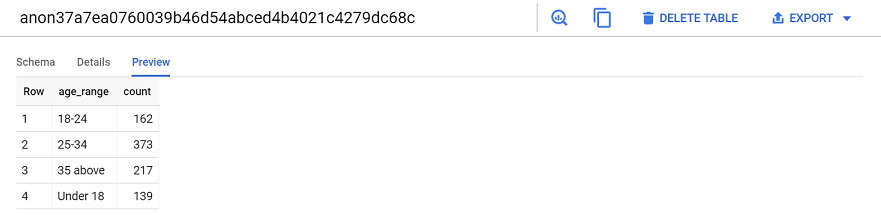

In [50]:
Image(filename='Images/age_updated.PNG')

### 1(d). We will combine more the one feature to extract better information from this dataset starting with age and sex

In [ ]:
select 
    case
        when age between 0 and 18   then 'Under 18'
        when age between 18 and 24  then '18-24'
        when age > 24 and age <= 34 then '25-34'
        when age > 34               then '35 above'
    END as age_range,
    Sex , 
    Survived,
    Count(*) as count
from `daring-span-249015.titanic_dataset.Train`
group by 
    Sex , 
    Survived, 
    age_range
order by 
    1, 
    3, 
    2;

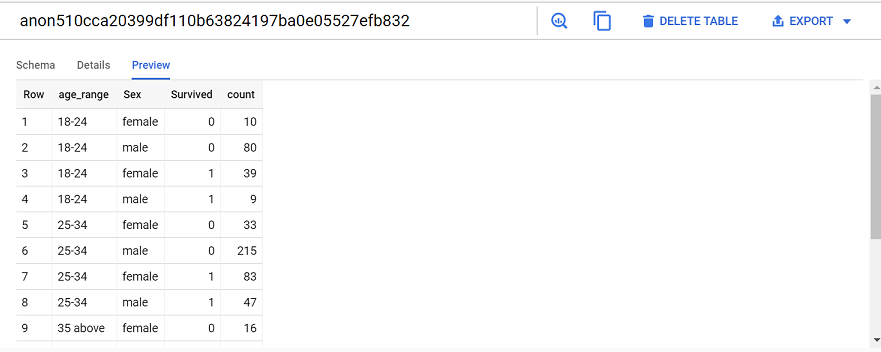

In [37]:
Image(filename='Images/age_sex.PNG')

In [ ]:
select 
    Pclass,
    Sex , 
    Survived , 
    Count(*)
from `daring-span-249015.titanic_dataset.Train`
group by 
    Pclass,
    Sex, 
    Survived
order by 
    Pclass,
    Survived, 
    sex;

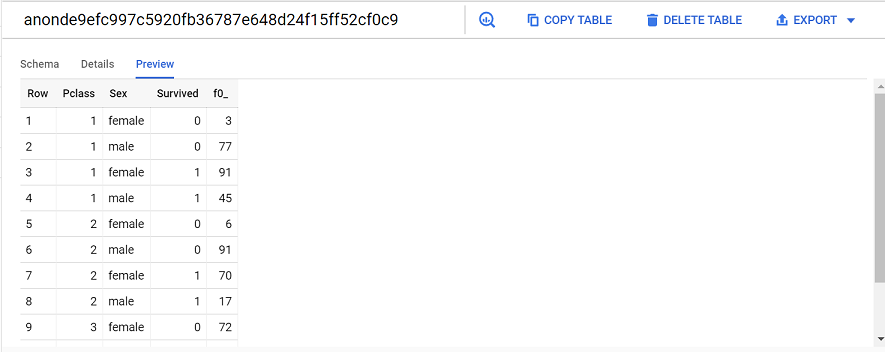

In [51]:
Image(filename='Images/sex_pclass.PNG')

In [ ]:
select
    Sex , 
    Survived,
    Pclass,
    case
        when age between 0 and 18   then '18 and below'
        when age between 18 and 24  then '18-24'
        when age > 24 and age <= 34 then '24-34'
        when age > 34               then 'Over 34'
    END as age_range,
    Count(*) as count
from `daring-span-249015.titanic_dataset.Train`
group by Pclass,Sex , Survived, age_range
order by Survived, Pclass, age_range, sex;

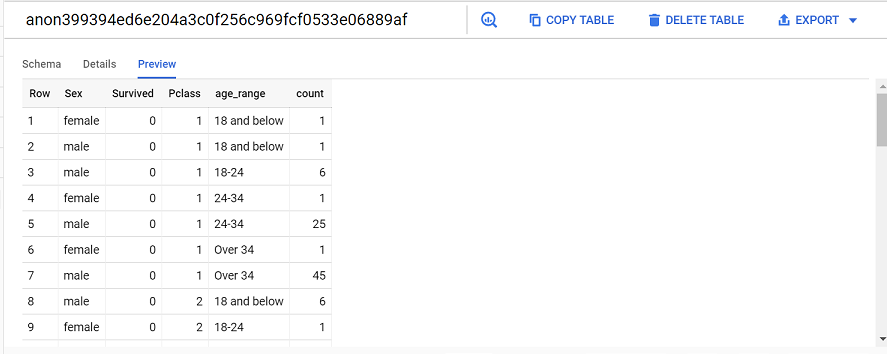

In [52]:
Image(filename='Images/age_sex_pclass.PNG')

In [ ]:
Select 
    Embarked , 
    Sex , 
    Survived , 
    Count(*)
from `daring-span-249015.titanic_dataset.Train`
group by 
    Embarked,
    Sex, 
    Survived
order by 
    Embarked,
    Survived, 
    sex;

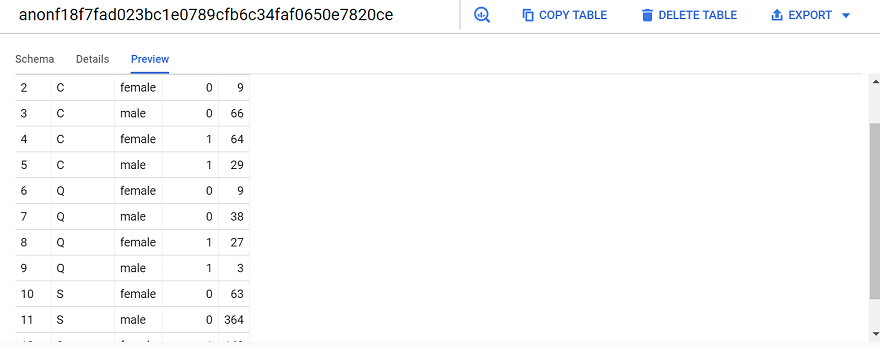

In [53]:
Image(filename='Images/embarked_sex.PNG')

### 2. Let us bring every Columns together to extract a complete table to be fed to Machine Learning Model

In [ ]:
select
    Sex , 
    Survived,
    Pclass,
    case
        when age between 0 and 18   then 1
        when age between 18 and 24  then 2
        when age > 24 and age <= 34 then 3
        when age > 34               then 4
    END as age_range,
    case
        when Embarked ='C' then 1
        when Embarked ='Q'  then 2
        when Embarked ='S' then 3
        when Embarked IS NULL then 4
    END AS point_of_embarkment,
    Count(*) as count
from `daring-span-249015.titanic_dataset.Train`
group by 
    Pclass,
    Sex , 
    Survived,
    Embarked, 
    age_range;

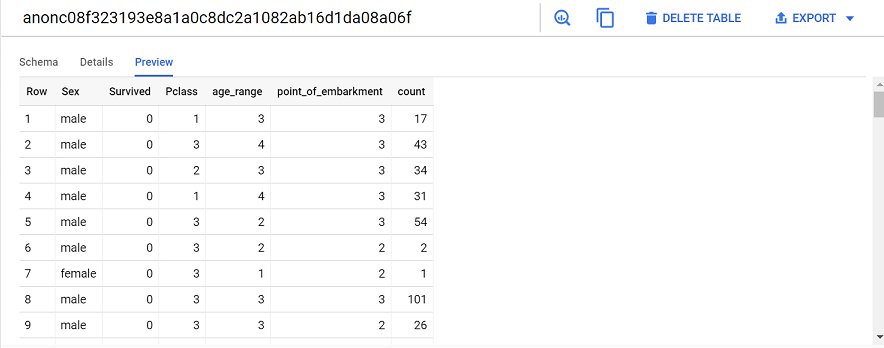

In [54]:
Image(filename='Images/all.PNG')

## 3. Now let us create a model using Logistic Regression to classify who survived and who did not

> The query below creates Classification learning model names "classification model". It takes Input from the select query we wrote below which extracts all the important details from the Train Dataset.

In [ ]:
CREATE OR REPLACE MODEL `daring-span-249015.titanic_dataset.classification_model`
OPTIONS
(
model_type='logistic_reg',
input_label_cols=['Survived']
)
AS
    select
        Sex ,
        Pclass,
        case
            when age between 0 and 18   then 1
            when age between 18 and 24  then 2
            when age > 24 and age <= 34 then 3
            when age > 34               then 4
        END as age_range,
        case
            when Embarked ='C' then 1
            when Embarked ='Q'  then 2
            when Embarked ='S' then 3
            when Embarked IS NULL then 4
        END AS point_of_embarkment,
        SibSp,
        Parch,
        Survived
    from `daring-span-249015.titanic_dataset.Train`
    group by 
            Pclass,
            Sex ,
            Embarked, 
            age_range, 
            SibSp, 
            parch, 
            Survived;

In [ ]:
SELECT * FROM
ML.EVALUATE 
 (MODEL `daring-span-249015.titanic_dataset.classification_model`, 
 (select
    Sex ,
    Pclass,
    case
     when age between 0 and 18   then 1
     when age between 18 and 24  then 2
     when age > 24 and age <= 34 then 3
     when age > 34               then 4
    END as age_range,
    case
     when Embarked ='C' then 1
     when Embarked ='Q'  then 2
     when Embarked ='S' then 3
     when Embarked IS NULL then 4
    END AS point_of_embarkment,
    SibSp,
    Parch,
    Survived
   from `daring-span-249015.titanic_dataset.Train`
   group by 
      Pclass,
      Sex ,
      Embarked, 
      age_range, 
      SibSp, 
      parch, 
      Survived)
 );

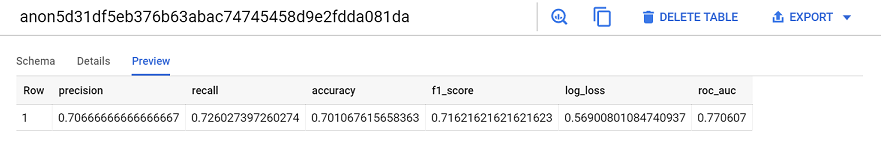

In [55]:
Image(filename='Images/ML_evaluate.PNG')

> Now let us just try to Predict the values on Testing Dataset. 

In [ ]:
SELECT * FROM
ML.PREDICT(MODEL `daring-span-249015.titanic_dataset.classification_model`, 
(select
    Sex ,
    Pclass ,
    case
         when age between 0 and 18   then 1
         when age between 18 and 24  then 2
         when age > 24 and age <= 34 then 3
         when age > 34               then 4
    END as age_range,
    case
         when Embarked ='C' then 1
         when Embarked ='Q'  then 2
         when Embarked ='S' then 3
         when Embarked IS NULL then 4
    END AS point_of_embarkment,
    SibSp,
    Parch
   from `daring-span-249015.titanic_dataset.Test`
   group by 
    Pclass,
    Sex ,
    Embarked, 
    age_range, 
    SibSp, 
    parch)
)

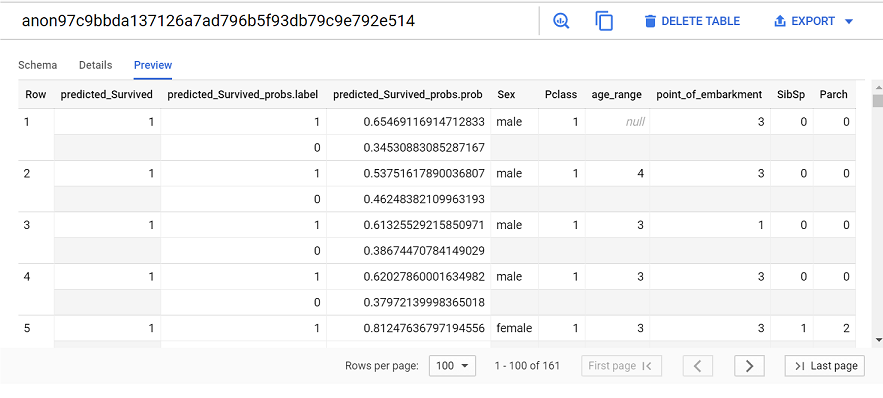

In [56]:
Image(filename='Images/predict.PNG')